# Morphological Graph from Overture Maps with city2graph

This notebook demonstrates how to create **morphological graph** using `city2graph` and data from Overture Maps. Morphological graph provide a comprehensive graph representation of urban form that captures the relationships between public and private spaces in cities.

## What are Morphological Graphs?

Morphological graphs are heterogeneous graphs where:
- **Nodes** represent both public spaces (street segments) and private spaces (enclosed areas/tessellations)
- **Edges** capture three types of spatial relationships:
  - 🔴 **Private-to-private**: Adjacency between neighboring private spaces
  - 🔵 **Public-to-public**: Connectivity along street networks (dual graph representation)
  - 🟣 **Private-to-public**: Interface between private spaces and adjacent streets

## Workflow Overview

1. **Data Loading**: Import building footprints and street segments from Overture Maps
2. **Data Processing**: Clean and prepare spatial data for network creation
3. **Morphological Graph Generation**: Create tessellations and extract spatial relationships
4. **Graph Conversion**: Convert to PyTorch Geometric for machine learning applications
5. **Visualization**: Explore the resulting morphological graph

This approach enables advanced urban analytics including connectivity analysis, accessibility studies, and graph-based machine learning for urban form analysis.

## 1. Setup and Dependencies

In [1]:
# Core libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely import Point

# city2graph for morphological graph analysis
import city2graph

# Configure matplotlib for high-quality visualizations
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')

print("✅ Dependencies loaded successfully")
print(f"city2graph version: {city2graph.__version__}")
print(f"geopandas version: {gpd.__version__}")

✅ Dependencies loaded successfully
city2graph version: 0.1.1
geopandas version: 1.0.1


## 2. Loading Data from Overture Maps

We'll work with real urban data from Liverpool, UK, using Overture Maps which provides high-quality, open geospatial data including:
- **Building footprints**: Representing private/built spaces
- **Road segments**: Representing the street network
- **Connectors**: Intersection points in the road network

The data covers Liverpool city centre and demonstrates how city2graph can process real-world urban environments.

In [2]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Liverpool city centre

bbox = [-3.090173, 53.355487, -2.917138, 53.465587]  # Liverpool city centre bounding box

city2graph.load_overture_data(
    area=bbox,
    types=["segment", "building", "connector"], 
    output_dir=".",
    prefix="liverpool_",
    save_to_file=True,
    return_data=False
)

print("Data loading configuration complete")
print("To download fresh data, uncomment the city2graph.load_overture_data() call above")

Data loading configuration complete
To download fresh data, uncomment the city2graph.load_overture_data() call above


In [3]:
# Load the downloaded GeoJSON files
buildings_gdf = gpd.read_file("liverpool_building.geojson")
segments_gdf = gpd.read_file("liverpool_segment.geojson") 
connectors_gdf = gpd.read_file("liverpool_connector.geojson")

# Convert to British National Grid (EPSG:27700) for accurate distance calculations
buildings_gdf = buildings_gdf.to_crs(epsg=27700)
segments_gdf = segments_gdf.to_crs(epsg=27700)
connectors_gdf = connectors_gdf.to_crs(epsg=27700)

print("✅ Data loaded successfully!")
print(f"📊 Dataset summary:")
print(f"   • Buildings: {len(buildings_gdf):,}")
print(f"   • Road segments: {len(segments_gdf):,}")
print(f"   • Connectors: {len(connectors_gdf):,}")
print(f"   • CRS: {buildings_gdf.crs}")

✅ Data loaded successfully!
📊 Dataset summary:
   • Buildings: 131,680
   • Road segments: 37,891
   • Connectors: 47,699
   • CRS: EPSG:27700


## 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [4]:
# Filter to keep only road segments (excluding pedestrian paths, railways, etc.)
segments_gdf = segments_gdf[segments_gdf["subtype"] == "road"].copy()

# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf = city2graph.process_overture_segments(
    segments_gdf=segments_gdf,
    get_barriers=True,
    connectors_gdf=connectors_gdf
)

print(f"✅ Processed {len(segments_gdf)} road segments")
print(f"📈 Barrier geometries created for tessellation")

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf["barrier_geometry"].geom_type.value_counts()
print(f"\n🔍 Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

✅ Processed 62577 road segments
📈 Barrier geometries created for tessellation

🔍 Barrier geometry types:
   • LineString: 61,635
   • MultiLineString: 526


## 4. Creating Morphological Graphs

Now we'll create the morphological graph - the core contribution of city2graph. This process:

<div align="center">
    <img src="../_static/morph_net_process.png" alt="Morphological Graph Process" width="800"/>
</div>

### The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
   - **Private-to-private** (red): Adjacency between neighboring private spaces
   - **Public-to-public** (blue): Connectivity along street networks 
   - **Private-to-public** (purple): Interface between private spaces and streets

### Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [5]:
# Define center point for the analysis area (Liverpool city centre)
center_point = gpd.GeoSeries([Point(-2.9879004, 53.4062724)], crs='EPSG:4326').to_crs(epsg=27700)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

Removed 8 invalid geometries


🏗️  Creating morphological graph...


/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Morphological graph created successfully!
📊 Network summary:
   • Node types: ['private', 'public']
   • Edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]
   • Private spaces: 1,342
   • Public spaces: 781
   • ('private', 'touched_to', 'private'): 625 connections
   • ('public', 'connected_to', 'public'): 1,432 connections
   • ('private', 'faced_to', 'public'): 2,448 connections


In [6]:
morpho_nodes["private"].head()

geometry  \
private_id                                                      
0_73269     POLYGON ((333996.175 390450.527, 334003.086 39...   
1_73271     POLYGON ((334073.913 390420.014, 334030.706 39...   
1_73271     POLYGON ((334073.913 390420.014, 334030.706 39...   
1_73318     POLYGON ((334043.525 390481.046, 334080.22 390...   
1_73318     POLYGON ((334043.525 390481.046, 334080.22 390...   

            enclosure_index                                    id  version  \
private_id                                                                   
0_73269                   0  b1ad14ae-8c81-4ce8-8454-161b6f353e79      1.0   
1_73271                   1  92d2d106-2d0a-4005-859f-553a7977c3bb      1.0   
1_73271                   1  d6049d94-e246-4249-94ee-f0e7c7c3edf1      1.0   
1_73318                   1  92d2d106-2d0a-4005-859f-553a7977c3bb      1.0   
1_73318                   1  d6049d94-e246-4249-94ee-f0e7c7c3edf1      1.0   

                                                      sources  level  \
private_id                                                             
0_73269     [ { "property": "", "dataset": "OpenStreetMap"...    NaN   
1_73271     [ { "property": "", "dataset": "OpenStreetMap"...    NaN   
1_73271     [ { "property": "", "dataset": "OpenStreetMap"...    NaN   
1_73318     [ { "property": "", "dataset": "OpenStreetMap"...    NaN   
1_73318     [ { "property": "", "dataset": "OpenStreetMap"...    NaN   

               subtype       class     height  \
private_id                                      
0_73269           None        None  28.712467   
1_73271     commercial  commercial        NaN   
1_73271           None        None        NaN   
1_73318     commercial  commercial        NaN   
1_73318           None        None        NaN   

                                                        names  ...  \
private_id                                                     ...   
0_73269                                                  None  ...   
1_73271     { "primary": "Oriel Chambers", "common": null,...  ...   
1_73271                                                  None  ...   
1_73318     { "primary": "Oriel Chambers", "common": null,...  ...   
1_73318                                                  None  ...   

           num_floors_underground facade_color  facade_material  \
private_id                                                        
0_73269                       NaN         None             None   
1_73271                       NaN         None             None   
1_73271                       NaN         None             None   
1_73318                       NaN         None             None   
1_73318                       NaN         None             None   

            roof_material  roof_shape roof_direction roof_orientation  \
private_id                                                              
0_73269              None        None            NaN             None   
1_73271              None        None            NaN             None   
1_73271              None        None            NaN             None   
1_73318              None        None            NaN             None   
1_73318              None        None            NaN             None   

           roof_color roof_height  \
private_id                          
0_73269          None         NaN   
1_73271          None         NaN   
1_73271          None         NaN   
1_73318          None         NaN   
1_73318          None         NaN   

                                            building_geometry  
private_id                                                     
0_73269     POLYGON ((333967.48 390438.231, 333961.101 390...  
1_73271     POLYGON ((334072.247 390432.443, 334042.191 39...  
1_73271     POLYGON ((334039.203 390482.652, 334011.103 39...  
1_73318     POLYGON ((334072.247 390432.443, 334042.191 39...  
1_73318     POLYGON ((334039.203 390482.652, 334011.103 39...  

[5 rows x 24 column

In [7]:
morpho_nodes["public"].head()

id  version  \
public_id                                                    
19002      7b5985b6-c166-49f2-b1a1-7f45b89d94e9_3        1   
19020        25a21c5f-f422-41f6-bf58-02830ae964c0        1   
19028      a0c1cc45-6490-4bc2-97b2-177a40a99a79_2        1   
19268        94a11c21-fab8-4b2e-b959-614bc13823f8        1   
19269        722e3a9a-55c1-47cd-8d0b-65699283adcf        1   

                                                     sources subtype  \
public_id                                                              
19002      [ { "property": "", "dataset": "OpenStreetMap"...    road   
19020      [ { "property": "", "dataset": "OpenStreetMap"...    road   
19028      [ { "property": "", "dataset": "OpenStreetMap"...    road   
19268      [ { "property": "", "dataset": "OpenStreetMap"...    road   
19269      [ { "property": "", "dataset": "OpenStreetMap"...    road   

                 class                                              names  \
public_id                                                                   
19002      residential  { "primary": "Red Cross Street", "common": nul...   
19020            steps                                               None   
19028          footway                                               None   
19268          footway                                               None   
19269          footway                                               None   

                                                  connectors routes  \
public_id                                                             
19002      [ { "connector_id": "6c0386a2-358f-4035-8f3f-3...   None   
19020      [ { "connector_id": "c4356229-c28c-4d24-a7ca-5...   None   
19028      [ { "connector_id": "17ff8cd1-9d37-49f1-9748-6...   None   
19268      [ { "connector_id": "bb947536-d581-4f5f-a7dd-e...   None   
19269      [ { "connector_id": "b2d24f4e-a0ba-4174-b26b-2...   None   

          subclass_rules access_restrictions  ...  \
public_id                                     ...   
19002               None                None  ...   
19020               None                None  ...   
19028               None                None  ...   
19268               None                None  ...   
19269               None                None  ...   

                                                  road_flags speed_limits  \
public_id                                                                   
19002                                                   None         None   
19020      [ { "values": [ "is_covered", "is_indoor" ], "...         None   
19028                                                   None         None   
19268                                                   None         None   
19269                                                   None         None   

          width_rules subclass  \
public_id                        
19002            None     None   
19020            None     None   
19028            None     None   
19268            None     None   
19269            None     None   

                                                    geometry split_from  \
public_id                                                                 
19002      LINESTRING (334226.058 390165.238, 334226.058 ...   0.581994   
19020      LINESTRING (334398.33 390102.797, 334395.759 3...        NaN   
19028      LINESTRING (334351.049 390179.304, 334350.437 ...   0.953679   
19268      LINESTRING (333977.592 390253.605, 333982.088 ...        NaN   
19269      LINESTRING (333985.416 390273.514, 333986.64 3...        NaN   

          split_to     length  \
public_id                       
19002          1.0  54.567144   
19020          NaN  37.723069   
19028          1.0   3.380212   
19268          NaN   5.360412   
19269          NaN   1.319952   

                                            barrier_geometry weight  
public_id                                                            
19002      LINESTRIN

In [8]:
morpho_edges[('public', 'connected_to', 'public')].head()

angle  \
from_public_id to_public_id               
19002          19001           2.015969   
               19565         174.500989   
19001          19565           7.514980   
19565          19566          82.043372   
               19575          54.023621   

                                                                      geometry  \
from_public_id to_public_id                                                      
19002          19001         LINESTRING (334247.285 390182.38, 334198.76 39...   
               19565         LINESTRING (334247.285 390182.38, 334244.186 3...   
19001          19565         LINESTRING (334198.76 390144.738, 334244.186 3...   
19565          19566         LINESTRING (334244.186 390186.688, 334264.683 ...   
               19575         LINESTRING (334244.186 390186.688, 334273.113 ...   

                            weight  
from_public_id to_public_id         
19002          19001          None  
               19565          None  
19001          19565          None  
19565          19566          None  
               19575          None

In [9]:
morpho_edges[('private', 'faced_to', 'public')].head()

geometry
private_id public_id                                                   
0_73269    19367      LINESTRING (333990.617 390408.84, 333990.894 3...
           19366      LINESTRING (333990.617 390408.84, 333987.115 3...
           19376      LINESTRING (333990.617 390408.84, 333994.021 3...
           19370      LINESTRING (333990.617 390408.84, 334001.27 39...
           19377      LINESTRING (333990.617 390408.84, 334015.167 3...

In [10]:
morpho_edges[('private', 'touched_to', 'private')].head()

enclosure_index  \
from_private_id to_private_id                    
1_73271         1_73318                      1   
6_93387         6_93388                      6   
6_93388         6_93389                      6   
13_93250        13_93403                    13   
                13_93426                    13   

                                                                        geometry  
from_private_id to_private_id                                                     
1_73271         1_73318        LINESTRING (334020.81 390464.168, 334054.803 3...  
6_93387         6_93388        LINESTRING (334707.371 390705.046, 334710.834 ...  
6_93388         6_93389        LINESTRING (334710.834 390762.232, 334742.808 ...  
13_93250        13_93403       LINESTRING (334754.659 390295.189, 334774.56 3...  
                13_93426       LINESTRING (334754.659 390295.189, 334778.092 ...

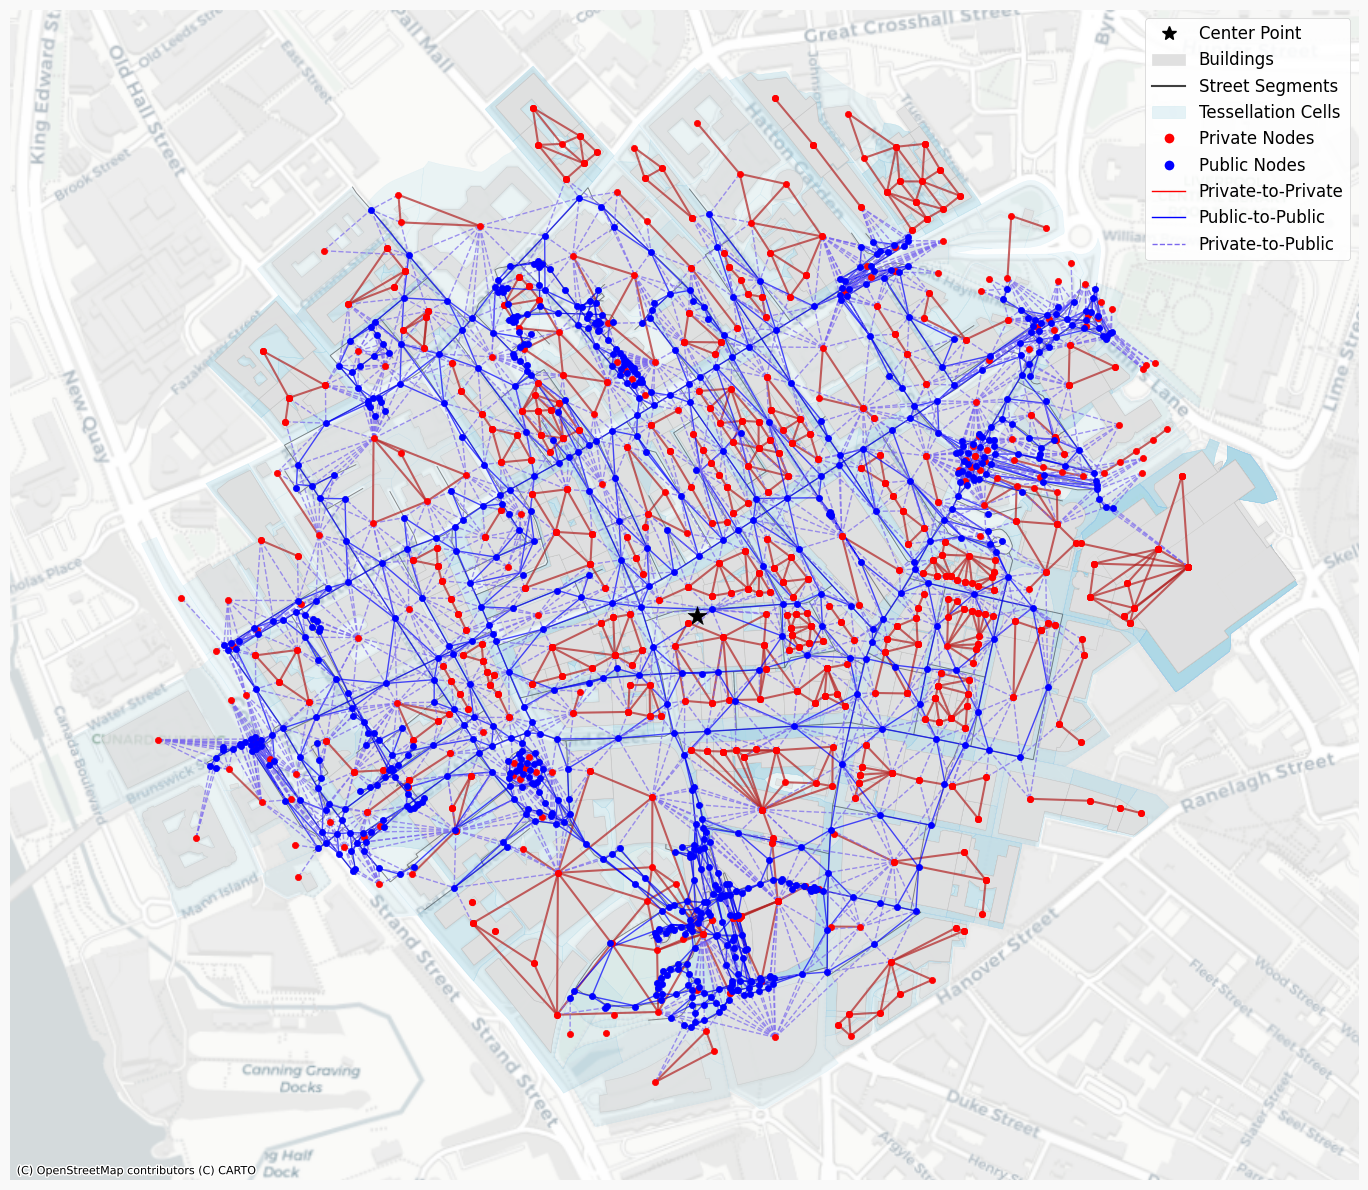

In [11]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

## 6. Converting to Graph Representations for Machine Learning

city2graph provides seamless conversion between spatial data and graph formats optimized for machine learning. We'll demonstrate conversion to PyTorch Geometric, enabling advanced graph neural network applications for urban analysis.

### Graph Format Support:
- **NetworkX**: For traditional graph analysis and algorithms
- **PyTorch Geometric**: For deep learning on graphs
- **GeoDataFrames**: For spatial analysis and visualization

This interoperability allows researchers to leverage the best tools for each analysis task.

In [12]:
# Check for PyTorch Geometric availability
import torch

try:
    import torch_geometric
    HAS_TORCH_GEOMETRIC = True
    print("✅ PyTorch Geometric successfully imported")
    print(f"   PyTorch version: {torch.__version__}")
    print(f"   PyTorch Geometric version: {torch_geometric.__version__}")
    print("🚀 Ready for graph representation learning!")
except ImportError:
    HAS_TORCH_GEOMETRIC = False
    print("⚠️  PyTorch Geometric not installed")
    print("   Install with: pip install torch-geometric")
    print("   Graph functionality will be limited to NetworkX")

✅ PyTorch Geometric successfully imported
   PyTorch version: 2.7.1
   PyTorch Geometric version: 2.6.1
🚀 Ready for graph representation learning!


### 6.1 Homogeneous Graph: Private Space Network

Let's start with a homogeneous graph focusing on private spaces (tessellation cells) and their adjacency relationships. This represents the spatial structure of plots and parcels in the urban environment.

In [13]:
# Compute spatial features for private spaces (tessellation cells)
morpho_nodes["private"]["area"] = morpho_nodes["private"].geometry.area
morpho_nodes["private"]["perimeter"] = morpho_nodes["private"].geometry.length
morpho_nodes["private"]["compactness"] = (
    4 * np.pi * morpho_nodes["private"]["area"] / (morpho_nodes["private"]["perimeter"] ** 2)
)

print("📊 Computed spatial features for private spaces:")
feature_stats = morpho_nodes["private"][['area', 'perimeter', 'compactness']].describe()
print(feature_stats.round(2))

# Set proper index names for graph conversion
morpho_nodes["private"].index.name = "tess_id"
morpho_edges[('private', 'touched_to', 'private')].index.names = ['from_private_id', 'to_private_id']

print("\n✅ Features computed and indices configured")

📊 Computed spatial features for private spaces:
           area  perimeter  compactness
count   1342.00    1342.00      1342.00
mean    1387.59     141.14         0.61
std     2800.88     110.93         0.15
min        0.00       0.00         0.03
25%      285.98      75.46         0.53
50%      564.02     107.44         0.64
75%     1294.72     162.18         0.73
max    23421.96     791.12         0.99

✅ Features computed and indices configured


In [14]:
if HAS_TORCH_GEOMETRIC:
    # Create homogeneous graph of private spaces
    private_graph = city2graph.gdf_to_pyg(
        nodes=morpho_nodes["private"],
        edges=morpho_edges[('private', 'touched_to', 'private')],
        node_feature_cols=['area', 'perimeter', 'compactness'],
        edge_feature_cols=None
    )
    
    print("🎯 Created homogeneous graph:")
    print(f"   • Nodes: {private_graph.num_nodes:,}")
    print(f"   • Edges: {private_graph.num_edges:,}")
    print(f"   • Node features: {private_graph.x.shape[1]} dimensions")
    print(f"   • Feature tensor shape: {private_graph.x.shape}")
    print("\n✅ Ready for graph neural network training!")
    
else:
    print("⚠️ Skipping PyTorch Geometric conversion (not installed)")
    private_graph = None

🎯 Created homogeneous graph:
   • Nodes: 1,342
   • Edges: 625
   • Node features: 3 dimensions
   • Feature tensor shape: torch.Size([1342, 3])

✅ Ready for graph neural network training!


#### Test Graph Conversions

Let's test the round-trip conversions between different graph formats to ensure data integrity:

### 6.2 Heterogeneous Graph: Complete Morphological Graph

Now let's create a heterogeneous graph that captures the full morphological graph with all node and edge types. This provides the complete representation for advanced urban analysis.

In [15]:
# Define center point for the analysis area (Liverpool city centre)
center_point = gpd.GeoSeries([Point(-2.9879004, 53.4062724)], crs='EPSG:4326').to_crs(epsg=27700)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

Removed 8 invalid geometries


🏗️  Creating morphological graph...


/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Morphological graph created successfully!
📊 Network summary:
   • Node types: ['private', 'public']
   • Edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]
   • Private spaces: 1,342
   • Public spaces: 781
   • ('private', 'touched_to', 'private'): 625 connections
   • ('public', 'connected_to', 'public'): 1,432 connections
   • ('private', 'faced_to', 'public'): 2,448 connections


In [16]:
# Compute features for public spaces (street segments)
morpho_nodes["public"]["length"] = morpho_nodes["public"].geometry.length

print("📊 Computed spatial features for public spaces:")
print(f"   • Street length statistics:")
length_stats = morpho_nodes["public"]["length"].describe()
print(f"     - Mean: {length_stats['mean']:.1f}m")
print(f"     - Median: {length_stats['50%']:.1f}m") 
print(f"     - Range: {length_stats['min']:.1f}m - {length_stats['max']:.1f}m")

print(f"\n✅ Features ready for heterogeneous graph creation")

📊 Computed spatial features for public spaces:
   • Street length statistics:
     - Mean: 24.5m
     - Median: 14.7m
     - Range: 0.8m - 153.9m

✅ Features ready for heterogeneous graph creation


In [17]:
if HAS_TORCH_GEOMETRIC:
    # Create heterogeneous graph with all morphological relationships
    hetero_graph = city2graph.gdf_to_pyg(
        morpho_nodes,
        morpho_edges,
        node_feature_cols={
            "private": ['area', 'perimeter', 'compactness'],
            "public": ['length']
        }
    )
    
    print("🌐 Created heterogeneous morphological graph:")
    print(f"   📊 Node types and counts:")
    for node_type in hetero_graph.node_types:
        num_nodes = hetero_graph[node_type].x.shape[0]
        num_features = hetero_graph[node_type].x.shape[1]
        print(f"     • {node_type}: {num_nodes:,} nodes, {num_features} features")
    
    print(f"   🔗 Edge types and counts:")
    for edge_type in hetero_graph.edge_types:
        num_edges = hetero_graph[edge_type].edge_index.shape[1]
        print(f"     • {edge_type}: {num_edges:,} edges")
    
    print("\n✅ Complete morphological graph ready for heterogeneous GNN training!")
    
else:
    print("⚠️ Skipping PyTorch Geometric conversion (not installed)")
    hetero_graph = None

🌐 Created heterogeneous morphological graph:
   📊 Node types and counts:
     • private: 1,342 nodes, 0 features
     • public: 781 nodes, 1 features
   🔗 Edge types and counts:
     • ('private', 'touched_to', 'private'): 625 edges
     • ('public', 'connected_to', 'public'): 1,432 edges
     • ('private', 'faced_to', 'public'): 2,448 edges

✅ Complete morphological graph ready for heterogeneous GNN training!


In [18]:
hetero_graph

HeteroData(
  crs=EPSG:27700,
  graph_metadata=<city2graph.utils.GraphMetadata object at 0x3068a1130>,
  private={
    x=[1342, 0],
    pos=[1342, 2],
  },
  public={
    x=[781, 1],
    pos=[781, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 625],
    edge_attr=[625, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1432],
    edge_attr=[1432, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 2448],
    edge_attr=[2448, 0],
  }
)

### 6.3 Using NetworkX

city2graph provides seamless conversion to NetworkX for traditional graph analysis and algorithms. This enables access to the rich ecosystem of graph analysis tools.

In [19]:
morpho_graph = city2graph.gdf_to_pyg(morpho_nodes,
                                     morpho_edges,
                                     node_feature_cols={"private": ['area', 'perimeter', 'compactness'],
                                                        "public": ['length']},)

# Convert morphological graph to NetworkX for traditional graph analysis
G_morpho = city2graph.gdf_to_nx(morpho_nodes, morpho_edges)

print("🔗 Converted to NetworkX:")
print(f"   • Total nodes: {G_morpho.number_of_nodes():,}")
print(f"   • Total edges: {G_morpho.number_of_edges():,}")
print(f"   • Graph type: {'Directed' if G_morpho.is_directed() else 'Undirected'}")

# Check if it's a heterogeneous graph
has_node_types = any('node_type' in data for _, data in G_morpho.nodes(data=True))
print(f"   • Heterogeneous: {'Yes' if has_node_types else 'No'}")

if has_node_types:
    # Count nodes by type
    from collections import Counter
    node_types = [data.get('node_type', 'unknown') for _, data in G_morpho.nodes(data=True)]
    type_counts = Counter(node_types)
    print(f"   • Node type distribution:")
    for node_type, count in type_counts.items():
        print(f"     - {node_type}: {count:,}")

print("\n✅ Ready for NetworkX graph analysis algorithms!")

🔗 Converted to NetworkX:
   • Total nodes: 2,123
   • Total edges: 4,505
   • Graph type: Undirected
   • Heterogeneous: Yes
   • Node type distribution:
     - private: 1,342
     - public: 781

✅ Ready for NetworkX graph analysis algorithms!


## 7. OpenStreetMap

As a reference, you can execute the same process using OpenStreetMap dataset, extracted by `osmnx`.

In [20]:
import osmnx as ox

# Download and create a street network graph for Liverpool, UK
G_osmnx = ox.graph_from_place("Liverpool, UK", network_type="all")

print(f"✅ OSMnx graph created for Liverpool, UK")
print(f"   • Nodes: {len(G_osmnx.nodes):,}")
print(f"   • Edges: {len(G_osmnx.edges):,}")

✅ OSMnx graph created for Liverpool, UK
   • Nodes: 44,624
   • Edges: 113,686


In [21]:
# Download POIs (amenities, shops, etc.) in Liverpool, UK
tags = {"building": True}
osm_buildings = ox.features_from_place("Liverpool, UK", tags)

print(f"✅ Retrieved {len(osm_buildings):,} buildings from OSMnx")
osm_buildings.head()

✅ Retrieved 75,227 buildings from OSMnx


geometry     building building:material  \
element id                                                                     
node    130190976   POINT (-2.92799 53.37127)          yes             brick   
        252558860     POINT (-2.91785 53.396)  residential               NaN   
        299317179   POINT (-2.97904 53.39175)          yes               NaN   
        1563152870  POINT (-2.91166 53.41248)  manufacture               NaN   
        1669223582  POINT (-2.96855 53.40601)          yes               NaN   

                   building:use                              name  \
element id                                                          
node    130190976     religious   Saint Anne's Parish Hall - 1902   
        252558860           NaN                    Bradbury House   
        299317179           NaN         Toxteth Ambulance Station   
        1563152870          NaN         Tom Williams Cake Factory   
        1669223582          NaN  ALL (Active Learning Laboratory)   

                            emergency       addr:street    shop  \
element id                                                        
node    130190976                 NaN               NaN     NaN   
        252558860                 NaN               NaN     NaN   
        299317179   ambulance_station               NaN     NaN   
        1563152870                NaN  Broad Green Road  pastry   
        1669223582                NaN               NaN     NaN   

                                          website addr:city  ...  \
element id                                                   ...   
node    130190976                             NaN       NaN  ...   
        252558860                             NaN       NaN  ...   
        299317179                             NaN       NaN  ...   
        1563152870  http://www.cakefactory.co.uk/       NaN  ...   
        1669223582                            NaN       NaN  ...   

                   naptan:PlusbusZoneRef naptan:ShortCommonName naptan:Street  \
element id                                                                      
node    130190976                    NaN                    NaN           NaN   
        252558860                    NaN                    NaN           NaN   
        299317179                    NaN                    NaN           NaN   
        1563152870                   NaN                    NaN           NaN   
        1669223582                   NaN                    NaN           NaN   

                   naptan:verified shelter type ref:edubase:group  \
element id                                                          
node    130190976              NaN     NaN  NaN               NaN   
        252558860              NaN     NaN  NaN               NaN   
        299317179              NaN     NaN  NaN               NaN   
        1563152870             NaN     NaN  NaN               NaN   
        1669223582             NaN     NaN  NaN               NaN   

                   school:trust:name school:trust:type manager  
element id                                                      
node    130190976                NaN               NaN     NaN  
        252558860                NaN               NaN     NaN  
        299317179                NaN               NaN     NaN  
        1563152870               NaN               NaN     NaN  
        1669223582               NaN               NaN     NaN  

[5 rows x 369 columns]

If you want to directly convert the `nx.MultiGraph` into `torch_geometric.data.Data`,

In [22]:
osm_data = city2graph.nx_to_pyg(G_osmnx)

In [23]:
osm_data

Data(x=[44624, 0], edge_index=[2, 113686], edge_attr=[113686, 0], pos=[44624, 2], crs=epsg:4326, graph_metadata=<city2graph.utils.GraphMetadata object at 0x3061ed910>)

Or you can convert it into `GeoDataFrame` that is compatible to other functions in `city2graph`, 

In [24]:
osm_street_nodes, osm_street_edges =city2graph.nx_to_gdf(G_osmnx)

In [25]:
osm_street_nodes.head()

y         x  street_count                   geometry  \
324206  53.407123 -2.884331             3  POINT (-2.88433 53.40712)   
324209  53.405943 -2.896571             3  POINT (-2.89657 53.40594)   
324210  53.406113 -2.896688             3  POINT (-2.89669 53.40611)   
324216  53.406488 -2.899987             3  POINT (-2.89999 53.40649)   
324217  53.407391 -2.902198             3   POINT (-2.9022 53.40739)   

                  highway  ref junction  
324206                NaN  NaN      NaN  
324209                NaN  NaN      NaN  
324210  motorway_junction    4      NaN  
324216                NaN  NaN      NaN  
324217                NaN  NaN      NaN

In [26]:
osm_street_edges.head()

osmid  \
324206 324209      0  [28181793, 627409058, 546631471, 1155945617, 1...   
324209 3467956864  0                                           15215646   
324210 11385898804 0                                           15215652   
324216 21026685    0                                            4002276   
       21026680    0                                            4002284   

                         highway lanes                  maxspeed  oneway  \
324206 324209      0    motorway     3  [70 mph, 40 mph, 50 mph]    True   
324209 3467956864  0       trunk     3                    40 mph    True   
324210 11385898804 0     primary   NaN                    40 mph    True   
324216 21026685    0       trunk     3                    40 mph    True   
       21026680    0  trunk_link   NaN                    40 mph    True   

                        ref reversed      length bridge  \
324206 324209      0    M62    False  823.913652    yes   
324209 3467956864  0  A5080    False   52.584979    NaN   
324210 11385898804 0  A5080    False   32.304470    NaN   
324216 21026685    0  A5080    False   87.887476    NaN   
       21026680    0    NaN    False   61.909425    NaN   

                                                               geometry  \
324206 324209      0  LINESTRING (-2.88433 53.40712, -2.88494 53.407...   
324209 3467956864  0  LINESTRING (-2.89657 53.40594, -2.89678 53.405...   
324210 11385898804 0  LINESTRING (-2.89669 53.40611, -2.89629 53.406...   
324216 21026685    0  LINESTRING (-2.89999 53.40649, -2.90028 53.406...   
       21026680    0  LINESTRING (-2.89999 53.40649, -2.90029 53.406...   

                     weight               name junction service access width  \
324206 324209      0   None                NaN      NaN     NaN    NaN   NaN   
324209 3467956864  0   None  Bowring Park Road      NaN     NaN    NaN   NaN   
324210 11385898804 0   None  Bowring Park Road      NaN     NaN    NaN   NaN   
324216 21026685    0   None    Edge Lane Drive      NaN     NaN    NaN   NaN   
       21026680    0   None                NaN      NaN     NaN    NaN   NaN   

                     est_width tunnel  
324206 324209      0       NaN    NaN  
324209 3467956864  0       NaN    NaN  
324210 11385898804 0       NaN    NaN  
324216 21026685    0       NaN    NaN  
       21026680    0       NaN    NaN

To constrcut a morphological graph,

In [27]:
osm_buildings = osm_buildings.to_crs(epsg=27700)
osm_street_edges = osm_street_edges.to_crs(epsg=27700)

In [28]:
# Exclude rows with point geometries from osm_buildings
osm_buildings = osm_buildings[osm_buildings.geometry.type != "Point"]

In [29]:
# Define center point for the analysis area (Liverpool city centre)
center_point = gpd.GeoSeries([Point(-2.9879004, 53.4062724)], crs='EPSG:4326').to_crs(epsg=27700)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=osm_buildings,
    segments_gdf=osm_street_edges,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

🏗️  Creating morphological graph...


/Users/yutasato/Projects/Liverpool/city2graph/.venv/lib/python3.13/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


✅ Morphological graph created successfully!
📊 Network summary:
   • Node types: ['private', 'public']
   • Edge types: [('private', 'touched_to', 'private'), ('public', 'connected_to', 'public'), ('private', 'faced_to', 'public')]
   • Private spaces: 1,488
   • Public spaces: 645
   • ('private', 'touched_to', 'private'): 571 connections
   • ('public', 'connected_to', 'public'): 1,280 connections
   • ('private', 'faced_to', 'public'): 3,238 connections


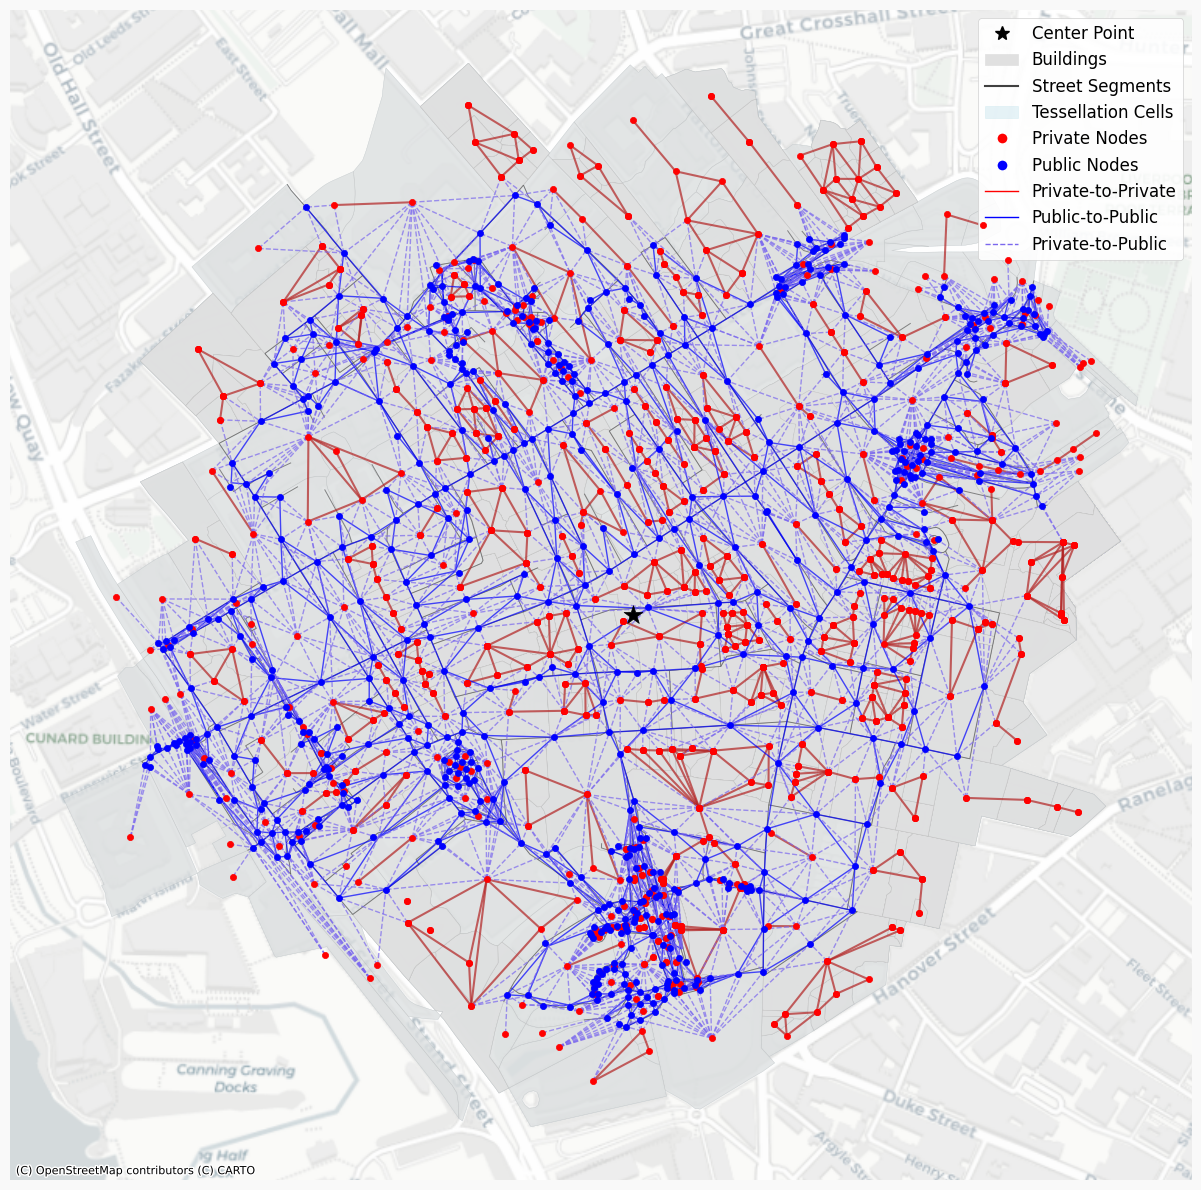

In [30]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right', 
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()

In [31]:
osm_hetero_data = city2graph.gdf_to_pyg(morpho_nodes, morpho_edges)

Removed 2 invalid geometries


In [32]:
osm_hetero_data

HeteroData(
  crs=EPSG:27700,
  graph_metadata=<city2graph.utils.GraphMetadata object at 0x179a577d0>,
  private={
    x=[1488, 0],
    pos=[1488, 2],
  },
  public={
    x=[645, 0],
    pos=[645, 2],
  },
  (private, touched_to, private)={
    edge_index=[2, 569],
    edge_attr=[569, 0],
  },
  (public, connected_to, public)={
    edge_index=[2, 1280],
    edge_attr=[1280, 0],
  },
  (private, faced_to, public)={
    edge_index=[2, 3238],
    edge_attr=[3238, 0],
  }
)

## 8. Summary
Congratulations! You've successfully created morphological graphs from Overture Maps data using city2graph. This workflow provides:

### What We've Accomplished:
**Data Integration**: Combined building footprints and street networks from Overture Maps  
**Morphological Analysis**: Created tessellations representing private urban spaces  
**Network Extraction**: Identified three types of spatial relationships  
**Graph Conversion**: Generated both homogeneous and heterogeneous graph representations  
**Machine Learning Ready**: Prepared data for PyTorch Geometric and NetworkX analysis  

### Applications Enabled:
- **Urban Connectivity Analysis**: Study how private and public spaces connect
- **Accessibility Research**: Measure spatial accessibility across urban areas  
- **Graph Neural Networks**: Apply deep learning to urban form analysis
- **Comparative Studies**: Analyze different cities using standardized representations
- **Planning Support**: Inform urban design with data-driven insights

### Next Steps:
1. **Add Urban Attributes**: Enrich nodes with POI data, demographics, or land use
2. **Multi-Scale Analysis**: Apply to different spatial scales (neighborhood to metropolitan)
3. **Temporal Studies**: Track urban evolution over time
4. **Machine Learning**: Train GNNs for prediction tasks (property values, accessibility, etc.)
5. **Cross-City Comparison**: Apply the same workflow to other cities

The morphological graph provides a foundation for sophisticated urban analysis that bridges traditional GIS approaches with modern graph machine learning techniques.

In [33]:
if HAS_TORCH_GEOMETRIC:
    import os
    import torch
    from torch_geometric.data import InMemoryDataset
    
    class MorphoGraphDataset(InMemoryDataset):
        """A PyTorch Geometric dataset for morphological graphs."""
        
        def __init__(self, root, transform=None, pre_transform=None):
            super().__init__(root, transform, pre_transform)
            if os.path.exists(self.processed_paths[0]):
                self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        
        @property
        def raw_file_names(self):
            return []
    
        @property
        def processed_file_names(self):
            return ['morpho_graph.pt']
        
        def download(self):
            # No download needed
            pass
            
        def process(self):
            # Use the existing morpho_graph as our single graph sample
            data_list = [hetero_graph]
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])
    
    # Create and save the dataset
    os.makedirs('./morpho_graph_dataset/processed', exist_ok=True)
    
    try:
        dataset = MorphoGraphDataset(root='./morpho_graph_dataset')
        print(f"💾 Dataset created and saved with {len(dataset)} graph(s)")
        print(f"   📁 Saved to: ./morpho_graph_dataset/")
        print("✅ Ready for future machine learning experiments!")
    except Exception as e:
        print(f"ℹ️  Dataset creation skipped: {e}")
        
else:
    print("ℹ️  Dataset creation skipped (PyTorch Geometric not available or no hetero_graph)")

print("\n🎉 Morphological graph analysis complete!")

💾 Dataset created and saved with 1 graph(s)
   📁 Saved to: ./morpho_graph_dataset/
✅ Ready for future machine learning experiments!

🎉 Morphological graph analysis complete!


## 8. Additional Resources

### Documentation and Examples:
- **city2graph Documentation**: [Full API reference and tutorials](https://city2graph.readthedocs.io/)
- **Overture Maps**: [Open geospatial data platform](https://overturemaps.org/)
- **PyTorch Geometric**: [Graph deep learning framework](https://pytorch-geometric.readthedocs.io/)

### Key Functions Used:
- `city2graph.load_overture_data()`: Download data from Overture Maps
- `city2graph.process_overture_segments()`: Clean and process street networks  
- `city2graph.morphological_graph()`: Create morphological graphs
- `city2graph.gdf_to_pyg()`: Convert to PyTorch Geometric format
- `city2graph.gdf_to_nx()`: Convert to NetworkX format